In [1]:
%matplotlib inline

import evident
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

plt.style.use("./paper.mplstyle")

In [2]:
lr_df = pd.read_table("../results/supplemental/prevotella_bacteroies_log_ratio.tsv", index_col=0)
lr_df["bmi"] = [">40" if x > 40 else "<25" for x in lr_df["bmi_v2"] ]
lr_df.head()

,num,denom,log_ratio,abdominal_obesity_ncep_v2,abdominal_obesity_idf_v2,bmi_v2,obese,bmi
S11666.G1749A,8918.0,1684.0,1.666900,1.0,1.0,46.087030,Yes,>40
S11666.G0757A,389.0,10096.0,-3.256315,1.0,1.0,42.142966,Yes,>40
S11666.G0611A,4869.0,1170.0,1.425885,0.0,1.0,20.937500,No,<25
S11666.G0280A,48.0,14731.0,-5.726508,0.0,0.0,20.571429,No,<25
S11666.G1397A,13.0,3275.0,-5.529124,0.0,1.0,23.878939,No,<25


In [3]:
_x = lr_df.query("bmi == '<25'")["log_ratio"]
_y = lr_df.query("bmi == '>40'")["log_ratio"]

diff = _y.mean() - _x.mean()
d = evident.stats.calculate_cohens_d(_x, _y)

print(diff, d)

1.0640825353291221 0.2697773916382893


In [4]:
power_df = pd.read_table("../results/supplemental/power_analysis.tsv")

def rename_diff(row):
    es = row["effect_size"]
    diff = row["difference"]
    return f"Difference = {diff} (d = {es:.2f})"

power_df["diff"] = power_df.apply(rename_diff, axis=1)
power_df.head()

,alpha,total_observations,power,effect_size,metric,column,difference,diff
0,0.05,100,0.096208,0.126765,cohens_d,obese,0.5,Difference = 0.5 (d = 0.13)
1,0.05,200,0.144946,0.126765,cohens_d,obese,0.5,Difference = 0.5 (d = 0.13)
2,0.05,300,0.194461,0.126765,cohens_d,obese,0.5,Difference = 0.5 (d = 0.13)
3,0.05,400,0.244043,0.126765,cohens_d,obese,0.5,Difference = 0.5 (d = 0.13)
4,0.05,500,0.293103,0.126765,cohens_d,obese,0.5,Difference = 0.5 (d = 0.13)


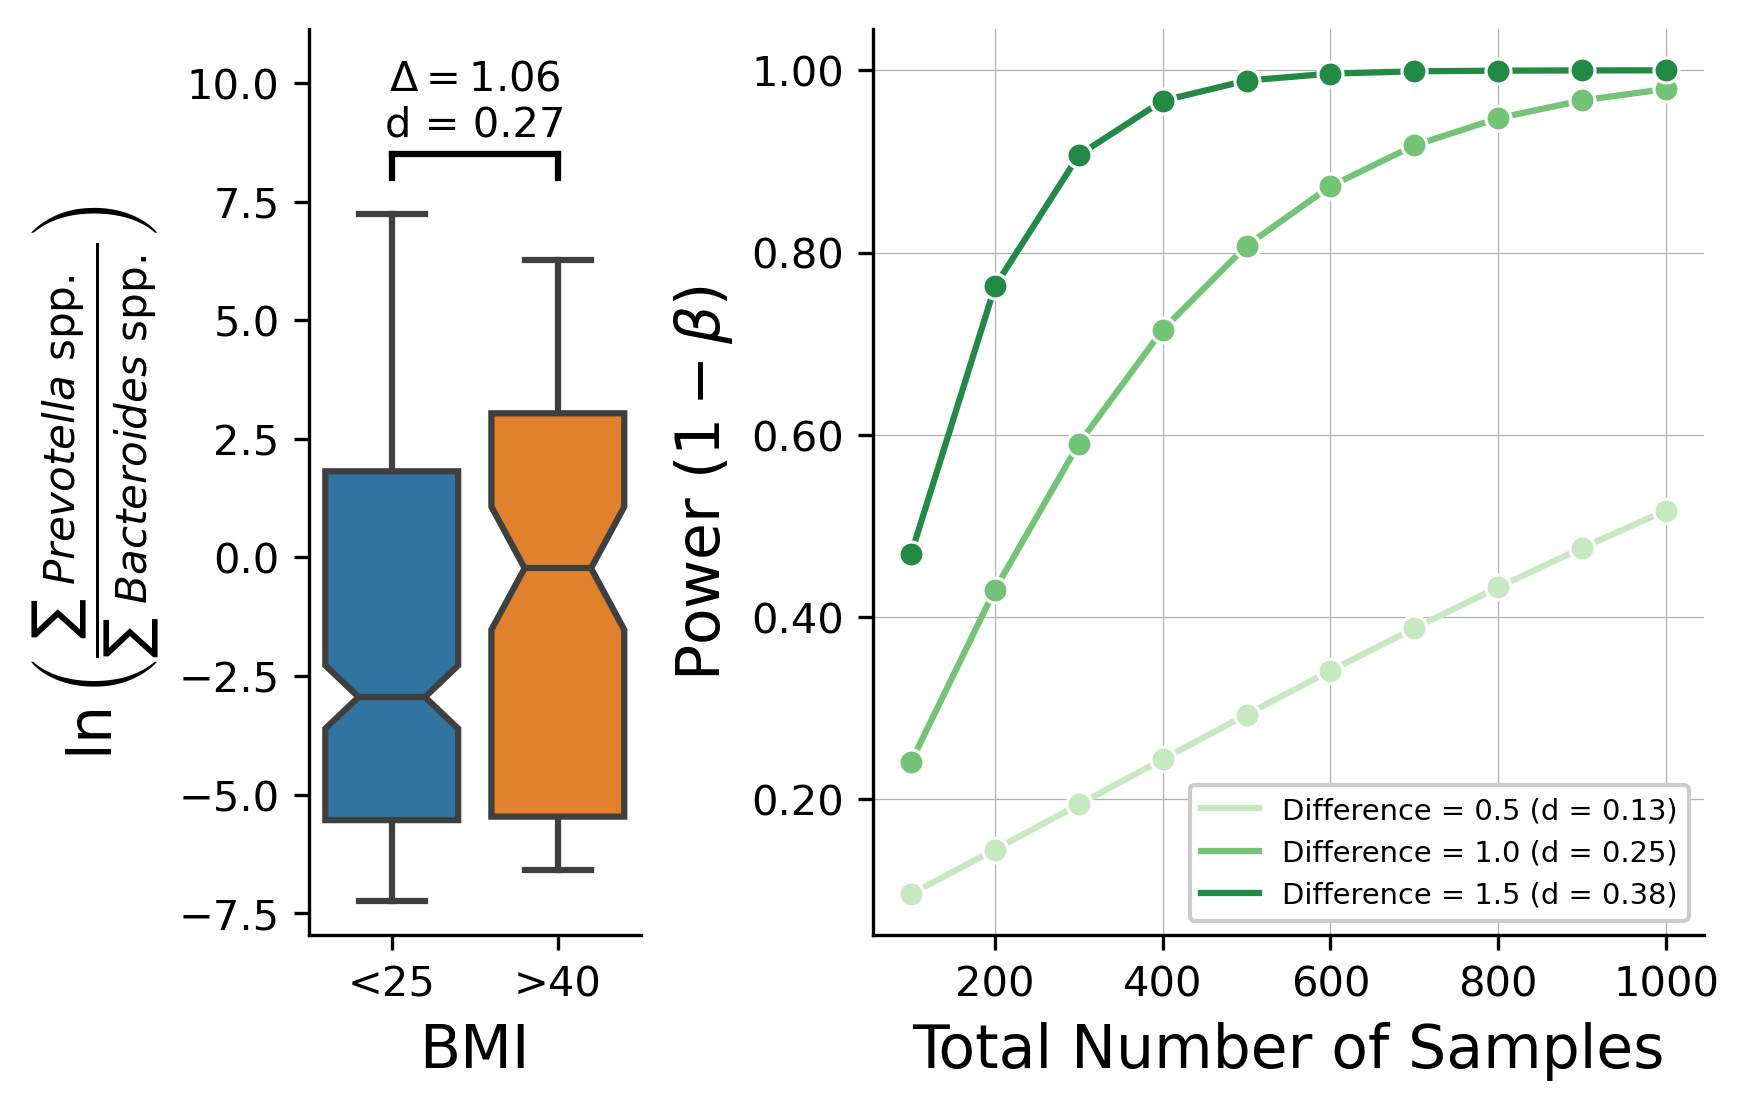

In [5]:
fig = plt.figure()
gs = GridSpec(ncols=2, nrows=1, width_ratios=[0.4, 1], wspace=0.4)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.boxplot(
    data=lr_df,
    x="bmi",
    y="log_ratio",
    notch=True,
    order=["<25", ">40"],
    ax=ax1
)
ax1.set_xlabel("BMI")
ax1.set_ylabel(r"$\ln\left(\frac{\sum\ Prevotella\ \mathrm{spp.}}{\sum\ Bacteroides\ \mathrm{spp.}}\right)$")

ymin, ymax = ax1.get_ylim()
yrange = ymax - ymin

ax1.plot(
    [0, 0],
    [8, 8.5],
    color="black"
)
ax1.plot(
    [1, 1],
    [8, 8.5],
    color="black"
)
ax1.plot(
    [0, 1],
    [8.5, 8.5],
    color="black"
)

ax1.text(
    x=0.5,
    y=8.7,
    s=r"$\Delta = $" + f"{diff:.2f}" + f"\nd = {d:.2f}",
    ha="center",
    va="bottom",
)

offset = 0.2
ymax_new = ymax + yrange*offset
ax1.set_ylim([ymin, ymax_new])

sns.lineplot(
    data=power_df,
    x="total_observations",
    y="power",
    hue="diff",
    marker="o",
    palette="Greens",
    ax=ax2
)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, framealpha=1)
ax2.set_xlabel("Total Number of Samples")
ax2.set_ylabel(r"Power ($1 - \beta$)")
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

ax2.grid()

plt.savefig("../figures/supp_prev_bact.pdf")
plt.show()

In [6]:
md = pd.read_table("../data/processed/metadata.disambig.filt.tsv", index_col=0)
countries = ["United States", "United Kingdom"]
md = md[md["country_of_birth"].isin(countries)]
md.shape

(7648, 89)

In [7]:
uk_es = pd.read_table("../results/supplemental/beta_effect_size_by_cat.United_Kingdom.tsv", index_col=0)
us_es = pd.read_table("../results/supplemental/beta_effect_size_by_cat.United_States.tsv", index_col=0)

uk_es = uk_es.set_index("column")
us_es = us_es.set_index("column")

uk_md = md[md["country_of_birth"] == "United Kingdom"]
us_md = md[md["country_of_birth"] == "United States"]

same_levels = []
for col in md.columns:
    uk_levels = set(uk_md[col].dropna().unique())
    us_levels = set(us_md[col].dropna().unique())
    if uk_levels == us_levels:
        same_levels.append(col)
        
uk_es = uk_es.rename(columns={"effect_size": "effect_size_UK"})

us_es = us_es.drop(columns=["metric"])
us_es = us_es.rename(columns={"effect_size": "effect_size_US"})

In [8]:
both_es = us_es.join(uk_es)
both_es = both_es.rename(columns={"metric": "Metric"})
both_es["Metric"] = both_es["Metric"].map({"cohens_d": "Cohen's d", "cohens_f": "Cohen's f"})
both_es.head()

,effect_size_US,effect_size_UK,Metric
column,,,
fungal_overgrowth,0.372997,0.038012,Cohen's d
clinical_condition,0.259406,0.143981,Cohen's d
autoimmune,0.247580,0.151223,Cohen's d
non_food_allergies_sun,0.212517,0.093147,Cohen's d
cardiovascular_disease,0.200686,0.018237,Cohen's d


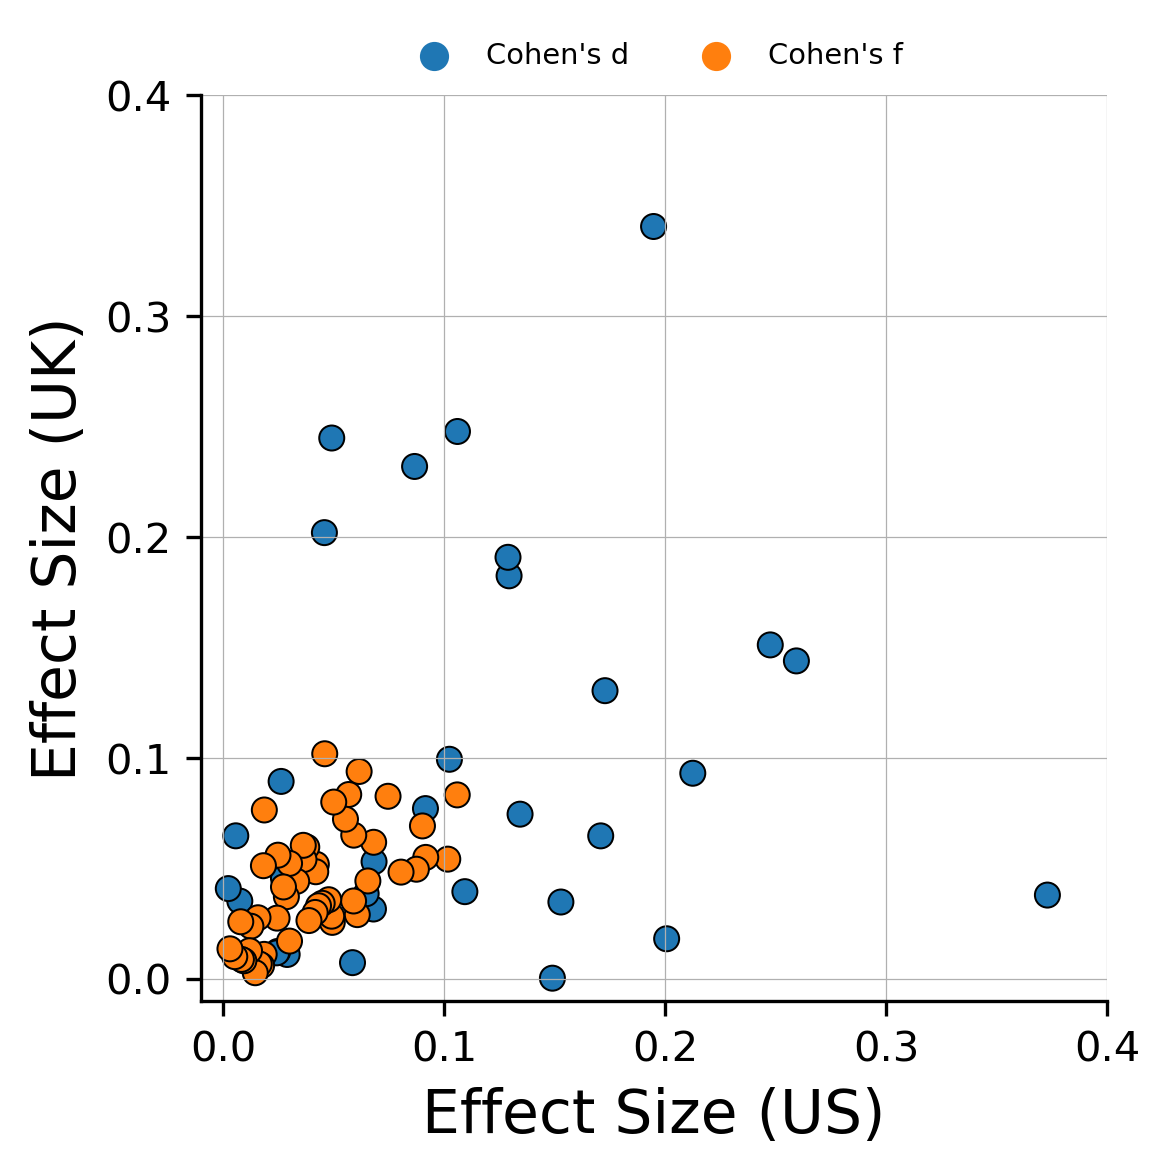

In [9]:
from matplotlib import ticker

fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")

sns.scatterplot(
    data=both_es,
    x="effect_size_US",
    y="effect_size_UK",
    hue="Metric",
    edgecolor="black",
    ax=ax
)

ax.set_xlim([-0.01, 0.4])
ax.set_ylim([-0.01, 0.4])

ax.set_xlabel("Effect Size (US)")
ax.set_ylabel("Effect Size (UK)")

ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

ax.grid()

ax.legend(
    framealpha=0,
    loc="lower center",
    ncol=2,
    bbox_to_anchor=[0.5, 1]
)

plt.savefig("../figures/supp_us_uk.pdf")
plt.show()

In [10]:
both_es.corr("spearman")

,effect_size_US,effect_size_UK
effect_size_US,1.000000,0.536074
effect_size_UK,0.536074,1.000000
